# Real Bogus Experiment

We used two subtraction techniques

Zackay's and Bramich's DIA algorithms.
Both were applied on the same new--ref pair of images and the same source identification algorithm.
Both dataset are comparable... 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set_context(font_scale=1.2)

In [3]:
from sqlalchemy import create_engine
import pandas as pd

In [4]:
engine = create_engine('sqlite:///../RBpipeline/rbogus-dev.db')

Asking to the database for the undetected objects (False Negatives)

In [5]:
und_z = pd.read_sql_query("""SELECT * FROM Simulated INNER JOIN Undetected 
                          ON Simulated.id==Undetected.simulated_id""", 
                          engine)

In [6]:
und_b = pd.read_sql_query("""SELECT * FROM Simulated INNER JOIN UndetectedOIS 
                          ON Simulated.id==UndetectedOIS.simulated_id""", 
                          engine)

Querying the database to obtain the tables related to the detections.

In [63]:
dt_zps = pd.merge(pd.read_sql_table('Detected', engine),
                  pd.read_sql_query("""SELECT 
                                        Detected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM Detected
                                        LEFT JOIN Reals
                                            ON Detected.id==Reals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==Reals.simulated_id""", engine),
                  on='id', suffixes=('',''))

dt_ois = pd.merge(pd.read_sql_table('DetectedOIS', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedOIS.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedOIS
                                        LEFT JOIN RealsOIS
                                            ON DetectedOIS.id==RealsOIS.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsOIS.simulated_id""", engine),
                  on='id', suffixes=('',''))

In [64]:
# dt_ois.IS_REAL = dt_ois.IS_REAL.astype(int)
# dt_zps.IS_REAL = dt_zps.IS_REAL.astype(int)

### Analyzing the fraction of type of objects for each dataset

In [31]:
ois = [sum(dt_ois.IS_REAL), len(und_b), len(dt_ois.IS_REAL)-sum(dt_ois.IS_REAL)]
zps = [sum(dt_zps.IS_REAL), len(und_z), len(dt_zps.IS_REAL)-sum(dt_zps.IS_REAL)]
df2 = pd.DataFrame([zps, ois], columns=['Real', 'False Neg', 'Bogus'])

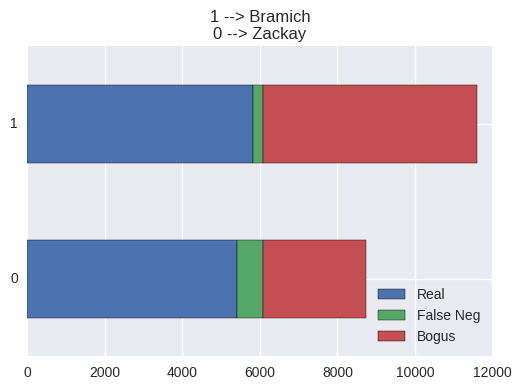

In [32]:
df2.plot.barh(stacked=True)
plt.title('1 --> Bramich\n0 --> Zackay')

## Magnitude offset

We need to calculate the magnitude offset to understand how to compare perfomances.

In [12]:
cx_zps = pd.read_sql_query(
"""SELECT 
  Detected.MAG_ISO, 
  Detected.MAG_AUTO, 
  Detected.MAG_APER,
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM Detected
  INNER JOIN Reals
    ON Detected.id==Reals.detected_id
  INNER JOIN Simulated
    ON Simulated.id==Reals.simulated_id""", engine)

In [13]:
cx_ois = pd.read_sql_query(
"""SELECT 
  DetectedOIS.MAG_ISO,
  DetectedOIS.MAG_AUTO,
  DetectedOIS.MAG_APER,
  Simulated.app_mag as sim_mag,
  Simulated.id as sim_id 
FROM DetectedOIS
  INNER JOIN RealsOIS
    ON DetectedOIS.id==RealsOIS.detected_id
  INNER JOIN Simulated
    ON Simulated.id==RealsOIS.simulated_id""", engine)

In [14]:
detections = pd.merge(cx_ois, cx_zps, on='sim_id', suffixes=('_ois','_zps'))

In [15]:
detections['MAG_OFFSET_zps'] = detections['sim_mag_zps'] - detections['MAG_APER_zps']
detections['MAG_OFFSET_ois'] = detections['sim_mag_ois'] - detections['MAG_APER_ois']

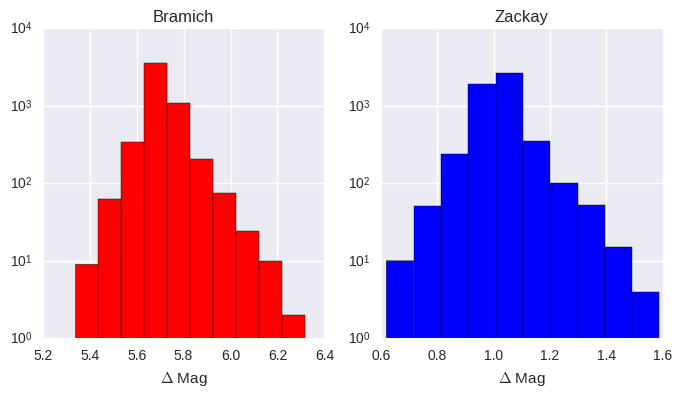

In [16]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.hist(detections['MAG_OFFSET_ois'], log=True, color='red')
plt.title('Bramich')
plt.xlabel(r'$\Delta$ Mag')
plt.subplot(122)
plt.hist(detections['MAG_OFFSET_zps'], log=True, color='blue')
plt.xlabel(r'$\Delta$ Mag')
plt.title('Zackay')
plt.show()

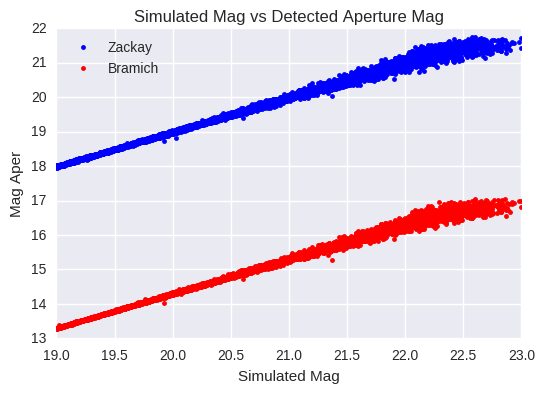

In [17]:
plt.plot(detections['sim_mag_zps'], detections['MAG_APER_zps'], 'b.', label='Zackay')
plt.plot(detections['sim_mag_ois'], detections['MAG_APER_ois'], 'r.', label='Bramich')
plt.ylabel('Mag Aper')
plt.xlabel('Simulated Mag')
plt.title('Simulated Mag vs Detected Aperture Mag')
plt.legend(loc='best')

In [18]:
print 'Mean magniutde difference for Zackay is {}'.format(detections.MAG_OFFSET_zps.mean())
print 'Mean magniutde difference for Bramich is {}'.format(detections.MAG_OFFSET_ois.mean())

Mean magniutde difference for Zackay is 1.02149233437
Mean magniutde difference for Bramich is 5.71458827083


In [66]:
dt_ois['mag'] = dt_ois['MAG_APER'] + detections.MAG_OFFSET_ois.mean()
dt_zps['mag'] = dt_zps['MAG_APER'] + detections.MAG_OFFSET_zps.mean()

In [68]:
bogus_b = dt_ois[dt_ois.IS_REAL==False]
reals_b = dt_ois[dt_ois.IS_REAL==True]

bogus_z = dt_zps[dt_zps.IS_REAL==False]
reals_z = dt_zps[dt_zps.IS_REAL==True]

## Luminosity function 

Bogus, Real, and FN luminosity functions.


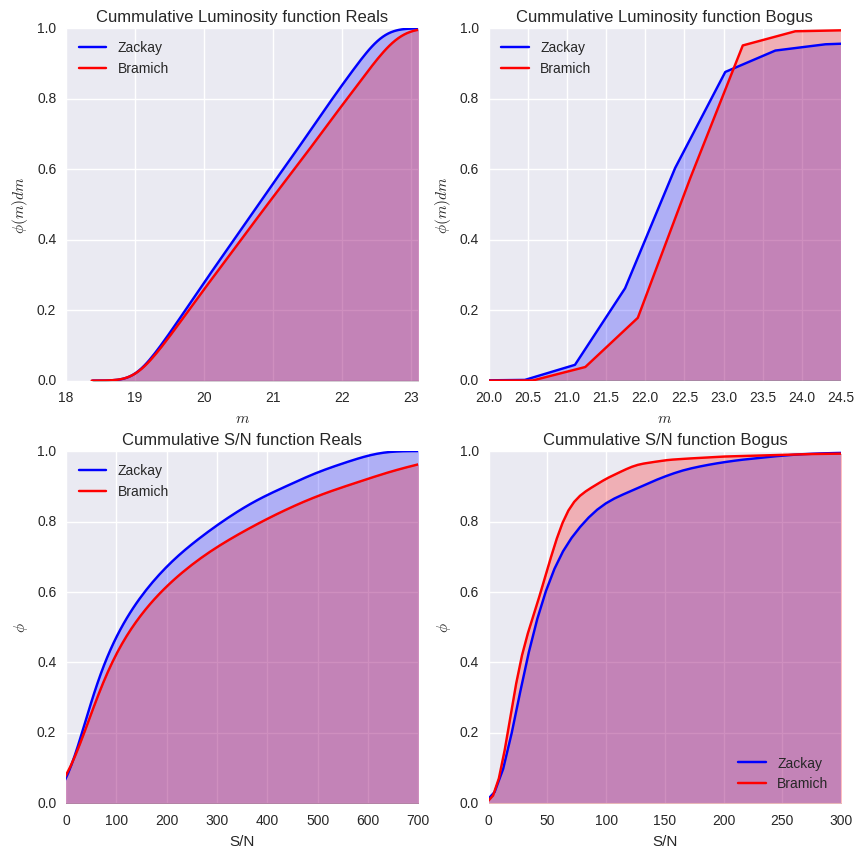

In [69]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.kdeplot(reals_z.mag, shade=True, cumulative=True, label='Zackay', color='blue')
sns.kdeplot(dt_ois[dt_ois.IS_REAL==True].mag, shade=True, cumulative=True, label='Bramich', color='red')
plt.xlim(18, 23.1)
plt.title('Cummulative Luminosity function Reals')
plt.ylabel(r'$\phi(m)dm$')
plt.legend(loc='best')
plt.xlabel(r'$m$')

plt.subplot(222)
sns.kdeplot(dt_zps[dt_zps.IS_REAL==False].mag, shade=True, cumulative=True, label='Zackay', color='blue')
sns.kdeplot(dt_ois[dt_ois.IS_REAL==False].mag, shade=True, cumulative=True, label='Bramich', color='red')
plt.xlim(20, 24.5)
plt.ylabel(r'$\phi(m)dm$')
plt.legend(loc='best')
plt.xlabel(r'$m$')
plt.title('Cummulative Luminosity function Bogus')

plt.subplot(223)
sns.kdeplot(dt_zps[dt_zps.IS_REAL==True].FLUX_ISO/dt_zps[dt_zps.IS_REAL==True].THRESHOLD, 
            shade=True, label='Zackay', color='blue', cumulative=True)
sns.kdeplot(dt_ois[dt_ois.IS_REAL==True].FLUX_ISO/dt_ois[dt_ois.IS_REAL==True].THRESHOLD, 
            shade=True, label='Bramich', color='red', cumulative=True)

plt.xlim(0, 700)
plt.title('Cummulative S/N function Reals')
plt.legend(loc='best')
plt.ylabel(r'$\phi$')
plt.xlabel('S/N')

plt.subplot(224)
sns.kdeplot(dt_zps[dt_zps.IS_REAL==False].FLUX_ISO/dt_zps[dt_zps.IS_REAL==False].THRESHOLD, 
            shade=True, label='Zackay', color='blue', cumulative=True)
sns.kdeplot(dt_ois[dt_ois.IS_REAL==False].FLUX_ISO/dt_ois[dt_ois.IS_REAL==False].THRESHOLD, 
            shade=True, label='Bramich', color='red', cumulative=True)

plt.xlim(0, 300)
plt.title('Cummulative S/N function Bogus')
plt.ylabel(r'$\phi$')
plt.legend(loc='best')
plt.xlabel('S/N')


plt.show()

### Luminosity function for Undetected

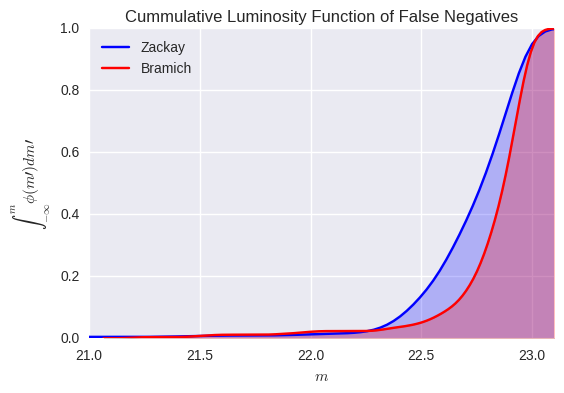

In [36]:
plt.figure()
sns.kdeplot(und_z.app_mag, cumulative=True, shade=True, color='blue', label='Zackay')
sns.kdeplot(und_b.app_mag, cumulative=True, shade=True, color='red', label='Bramich')
plt.legend(loc='best')
plt.ylabel(r'$\int_{-\infty}^{m}\phi(m\prime)dm\prime$')
plt.xlabel(r'$m$')
plt.title('Cummulative Luminosity Function of False Negatives')
plt.xlim(21., 23.1)
plt.show()

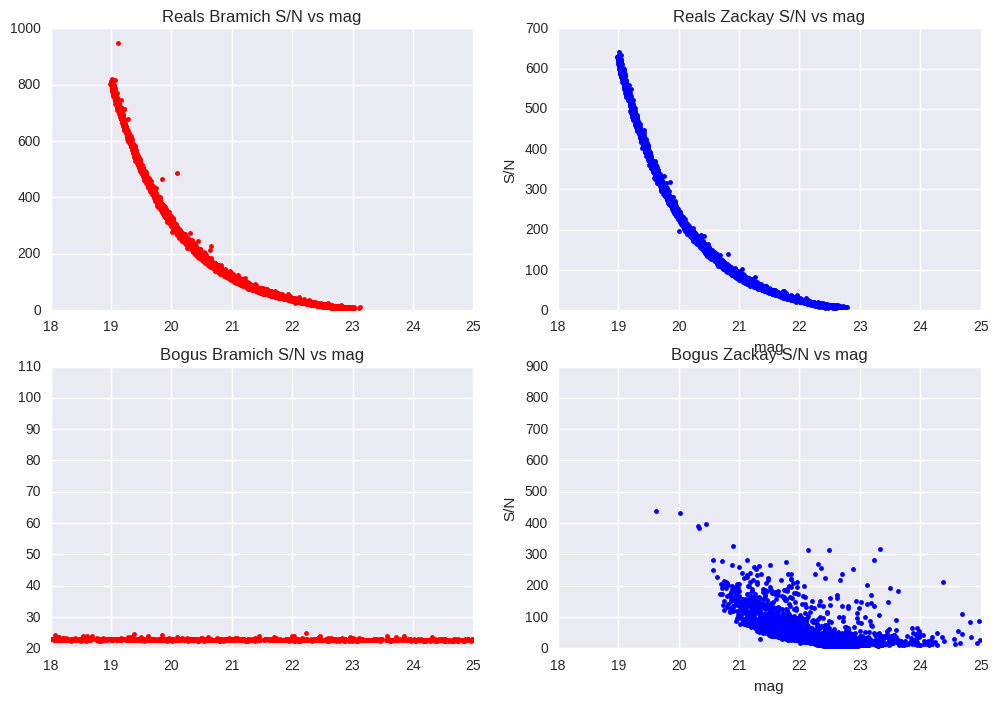

In [67]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Reals Bramich S/N vs mag')
plt.plot(reals_b.mag, 
         reals_b.FLUX_ISO/reals_b.THRESHOLD,
        '.r')
plt.xlim(18,25)

plt.subplot(222)
plt.title('Reals Zackay S/N vs mag')
plt.plot(reals_z.mag, 
         reals_z.FLUX_ISO/reals_z.THRESHOLD,
        '.b')

plt.xlim(18,25)
plt.ylabel('S/N')
plt.xlabel('mag')

plt.subplot(223)
plt.title('Bogus Bramich S/N vs mag')
plt.plot(bogus_b.FLUX_ISO/bogus_b.THRESHOLD,
             bogus_b.mag,
             '.r') 

plt.xlim(18,25)
plt.subplot(224)
plt.title('Bogus Zackay S/N vs mag')
plt.plot(bogus_z.mag, 
         bogus_z.FLUX_ISO/bogus_z.THRESHOLD,
        '.b')

plt.xlim(18,25)
plt.ylabel('S/N')
plt.xlabel('mag')

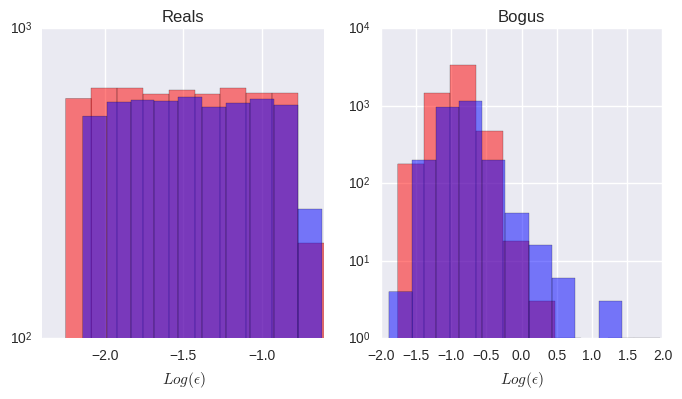

In [81]:

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Reals')
plt.hist(np.log10(reals_b.MAGERR_APER[reals_b.MAG_APER < 30]), log=True, alpha=0.5, color='red')
plt.hist(np.log10(reals_z.MAGERR_APER[reals_z.MAG_APER < 30]), log=True, alpha=0.5, color='blue')
plt.xlabel(r'$Log(\epsilon)$')

plt.subplot(122)
plt.title('Bogus')
plt.hist(np.log10(bogus_b.MAGERR_APER[bogus_b.MAG_APER < 30]), log=True, alpha=0.5, color='red')
plt.hist(np.log10(bogus_z.MAGERR_APER[bogus_z.MAG_APER < 30]), log=True, alpha=0.5, color='blue')
plt.xlabel(r'$Log(\epsilon)$')


## Checking on the outliers